# Analysis and Model for Predicting Earthquake Damage

## Project Overview:

On April 25th, 2015 Nepal was hit with an earthquake of magnitude 7.8 [Mw](https://en.wikipedia.org/wiki/Moment_magnitude_scale). It's effects were felt throughout Nepal and the surrounding regions of India, China and Bangladesh. Another major aftershock was felt on May 12th, 2015 with a magnitude of 7.3 Mw. 

This project investigates the features of buildings in the region of Nepal and aims at building a model that can predict the level of damage that was caused to the buildings during the 2015 earthquake. The findings from this study can be beneficial for reconstruction projects in the area and future construction projects can be guided in their choice of materials for buildings proposed in the region and surrounding areas. 

 

### Goals:

This project aims to:
- Investigate features of buildings in the region of Nepal to understand their relationship with the various degree of damage that was caused during the earthquake
- Predict the level of damage to buildings caused by the earthquake based on aspects of building location and construction.
- Understand the vulnerability of different building materials that are used in the region to alert architects and others involved in reconstruction or future construction projects



### Definitions:

- Damage Grade:
    - Damage Grade refers to the overall degree of damage caused to the buildings. The value ranges from 1 to 3:
        - Damage Grade 1: Relates to hairline or thin cracks in plaster on a few walls, damage to non structural parts like chimney, projecting cornices. Only architectural repairs needed. The load carrying capacity of the building is not reduced appreciably.
        - Damage Grade 2: Refers to large or extensive cracks in most walls, collapse of small portion of non load-bearing walls. Load carrying capacity of structure is partially reduced and significant structural repairs are required.
        - Damage Grade 3: Relates to total or near collapse of the buildings. Large gaps occur in walls, walls collapse, partial structural failure of floor/roof requiring reconstruction.
        

- Features:
    - Features refer to the independent variables we choose for our model to help predict the status of the buildings
    
    
- Target:
    - Damage Grade is our target variable which our model aims to predict. The target values are 1, 2, or 3


- Model:
    - The term model referred to through this project is in reference to the various classification models built to predict the status of the buildings.
    
    
    
- Recall score:
    - The metric used to compare the various models built. It is defined as the percent of correct results over the number of results that should have been returned. Recall score for Damage Grade 3 is computed for each model as this class is considered to be the most crucial to identify with the predictive models. The aim is to maximize this score.

    
### Data:

The data used in this project is from the 2015 Nepal Earthquake Open Data Portal and can be found [here](https://eq2015.npc.gov.np/#/download).  From this link, we can find the files/tables that were used in this project:
- Structural Data
- Building ownership and use

The data was collected through surveys by the Central Bureau of Statistics that work under the National Planning Commission Secretariat of Nepal. The survey is one of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics. 



### Analysis Takeaways, Future Investigations and Recommendations:

- Top predictive model was identified to be a Random Forest Classification Model
- The model was able to predict class 3 (building belonging to damage grade 3 requiring reconstruction) with a recall rate of 67%
- Our model showed very low variance based on its performance on our train, validation and test data, which gives us confidence in its generalizability.
- Important features identified from the top model eastablish relationship between the the building parameters and the building vulnerability in the event of an earthquake (of magnitude 7.8 Mw).
- The top features that increase the probability of a building to be classified as class 3 were identified to be:
    - buildings having super structure made of mud, mortar or stone
    - foundation of mud, mortar, stone or brick
    - buildings in the district of Sindhupalchok (district id 23)
- The top features that increase the probability of a building being classified as belonging to class 1 (requiring no major repairs) were:
    - Ground floor of buildings made with reinforced concrete
    - buildings in the region of Makwanpur (district id 31) and Okhaldhunga (district id 12)


### Fututre Investigations:
- From the identified important features from our current model further investigation can be conducted to establish relationship between the building features and the varrying damage grades. 
- Can a black box model such as a Neural Net give us better predictions for our 3 classes?
- Can we build an app that takes in parameters of buildings in the region of Nepal and give us predictions regarding their potential vulnerability (damage grade)


# Data Cleaning and Exploratory Data Analysis:

**Note**: Through out this project random_state was set to 2015 for reproducibility purpose.

## Get data:

Firstly, to get the data downloaded, run the cell in [this notebook](../exploratory/get_data_scripts.ipynb).  It will retrieve the files from the Open Data Portal website, unzip the folder, and move the csvs retrieved to the data folder in this repository. 

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [158]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import cleaning_functions as cfs
from src import preprocessing_functions as pfs
from src import modeling_functions as mfs
from sklearn.model_selection import train_test_split, GridSearchCV
import random
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import recall_score, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from prettytable import PrettyTable
import xgboost

First, we load our raw files to inspect the feature set and target

In [3]:
structure_df, ownership_df, ward_df = cfs.load_raw_files()

In [4]:
structure_df.head()

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
0,120101000011,12,1207,120703,1,1,9,288,9,9,...,0,0,0,1,0,0,0,Damaged-Used in risk,Grade 3,Major repair
1,120101000021,12,1207,120703,1,1,15,364,9,9,...,0,0,0,1,0,0,0,Damaged-Repaired and used,Grade 5,Reconstruction
2,120101000031,12,1207,120703,1,1,20,384,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
3,120101000041,12,1207,120703,1,1,20,312,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
4,120101000051,12,1207,120703,1,1,30,308,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 1,Minor repair


In [19]:
print('Shape of structure_df: ', structure_df.shape)
print('Number of unique districts: ', len(structure_df.district_id.unique()))
print('Number of unique municipalities: ', len(structure_df.vdcmun_id.unique()))
print('Number of unique wards: ', len(structure_df.ward_id.unique()))

Shape of structure_df:  (762106, 31)
Number of unique districts:  11
Number of unique municipalities:  110
Number of unique wards:  945


The main dataframe containing building parameters has `762106` datapoints relating to each unique building in the 11 most affected districts in Nepal.

First four columns relate to:
1) Unique building ids (762106 unique buildings)

2) District ids (11 districts)

3) Municipality ids (110 municipalities)

4) Ward ids (945 wards)

The remaining features relate to building information, the characteristics of the buildings with regards to their size, age, construction material and their behaviour after the impact of the earthquake.

In [9]:
structure_columns = structure_df.columns[4:]
for col in structure_columns:
    cfs.structure_df_unique_values(col)

Unique values for count_floors_pre_eq are :  [1 2 3 4 9 5 6 7 8]
Number of nulls for count_floors_pre_eq are :  0
Unique values for count_floors_post_eq are :  [1 0 2 3 4 9 5 6 8 7]
Number of nulls for count_floors_post_eq are :  0
Unique values for age_building are :  [  9  15  20  30  18  13   8  22  10   3   2   7  50  29  25  14  23  40
   1  82  35  60  45  11  32  16  27  12  65  33   4  24  47  99   5  70
  80  44  75  21   6  17  58  57  19  26  28  95  90  71  55  39  48  42
  85   0  38  52  56  59  84  46  68 105  51  41  62  61  36  34  78 100
  54  72  31  43  37  49  81  53  69 187 999  66  63 102  87  79 140  88
  64 120  93 115  86 130 160  92  77  73  67  83  76 101 110 176  74 200
 190 150 111 119  96  98  94  91  89 125 167  97 123 103 180 112 133 116
 145 114 121 144 108 122 155 172 132 131 106 148 113 109 165 118 117 107
 170 104 162 152 127 151 146 196 126 175 138 141 178 128 149 164 199 135
 166 168 156 161 142 185 173 136 177 174 124 134 193 195]
Number of nulls

Majority of our features are categorical. Some Nan values are observed 

The last three features `damage_grade`, `condition_post_earthquake`, and `technical_solution_proposed` are correlated. 

While trying to the gauge the relation between these three columns, `damage_grade` and `technical_solution_proposed` hinted towards a clear sub classifiction

In [44]:
structure_df[structure_df['technical_solution_proposed'] == 'Minor repair']['damage_grade'][:5]

2    Grade 2
3    Grade 2
4    Grade 1
5    Grade 2
7    Grade 2
Name: damage_grade, dtype: object

In [45]:
structure_df[structure_df['technical_solution_proposed'] == 'Major repair']['damage_grade'][:5]

0     Grade 3
8     Grade 3
9     Grade 3
16    Grade 3
18    Grade 3
Name: damage_grade, dtype: object

In [46]:
structure_df[structure_df['technical_solution_proposed'] == 'Reconstruction']['damage_grade'][:5]

1     Grade 5
6     Grade 5
39    Grade 5
44    Grade 5
50    Grade 4
Name: damage_grade, dtype: object

`damage_grade 1` and `damage_grade 2` correspond to *minor repairs*

`damage_grade 3` corresponds to *major repairs*

`damage_grade 4` and `damage_grade 5` correspond to *reconstruction*

Here's when we decide to bin *damage_grade* into three classes:

`class 1` = no repairs or `minor repairs`

`class 2` = `major repairs`

`class 3` = `reconstruction`

In [24]:
structure_df['target'] = structure_df.damage_grade.map({'Grade 1': 1, 'Grade 2': 1,
                                                        'Grade 3': 2,
                                                        'Grade 4': 3, 'Grade 5': 3})

#### Visualizing the building counts belonging to the three damage grade classes

![damage grades](../../report/figures/building_damage_grades.png)

About 60% of the buildings in our dataset belong to the reconstruction class, while the remaining 40% are divided between the grade 1 and grade 2 class.

Inspecting `ownership_df`

In [26]:
ownership_df.shape

(762106, 17)

In [27]:
ownership_df.head()

,building_id,district_id,vdcmun_id,ward_id,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,120101000011,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
1,120101000021,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
2,120101000031,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
3,120101000041,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
4,120101000051,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0


First 4 columns in `ownership_df` are identical to `structure_df`

In [31]:
sum(structure_df['building_id'] == ownership_df['building_id'])

762106

Inspecting the remaining features:

In [29]:
colnames = ownership_df.columns[4:]
for col in colnames:
    cfs.ownership_unique_values(col)

The unique values for legal_ownership_status :  ['Private' 'Other' 'Institutional' 'Public']
Number of nulls for legal_ownership_status are :  0
The unique values for count_families :  [ 1.  0.  2.  3.  4.  5.  6.  9.  7. nan  8. 11.]
Number of nulls for count_families are :  2
The unique values for has_secondary_use :  [ 0.  1. nan]
Number of nulls for has_secondary_use are :  10
The unique values for has_secondary_use_agriculture :  [0 1]
Number of nulls for has_secondary_use_agriculture are :  0
The unique values for has_secondary_use_hotel :  [0 1]
Number of nulls for has_secondary_use_hotel are :  0
The unique values for has_secondary_use_rental :  [0 1]
Number of nulls for has_secondary_use_rental are :  0
The unique values for has_secondary_use_institution :  [0 1]
Number of nulls for has_secondary_use_institution are :  0
The unique values for has_secondary_use_school :  [0 1]
Number of nulls for has_secondary_use_school are :  0
The unique values for has_secondary_use_industry

All categorical features noticed, some Nan values were also discovered.

Our next steps would be:
- check for duplicate entries
- combine the two dataframes

In [32]:
print(ownership_df.duplicated('building_id').sum())
print(structure_df.duplicated('building_id').sum())

0
0


In [33]:
data = pd.merge(structure_df, ownership_df, on=['building_id', 'district_id', 'vdcmun_id', 'ward_id'])

We can now drop some columns that are other versions of our identified `target` --->  `damage_grade`, `condition_post_earthquake`, and `technical_solution_proposed`

Also, since we plan to make our classification model generalizable to future building structures , we drop the columns relating to `height_ft_post_eq` and `count_floors_post_eq`

In [35]:
data.head()

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,120101000011,12,1207,120703,1,1,9,288,9,9,...,0,0,0,0,0,0,0,0,0,0
1,120101000021,12,1207,120703,1,1,15,364,9,9,...,0,0,0,0,0,0,0,0,0,0
2,120101000031,12,1207,120703,1,1,20,384,9,9,...,0,0,0,0,0,0,0,0,0,0
3,120101000041,12,1207,120703,1,1,20,312,9,9,...,0,0,0,0,0,0,0,0,0,0
4,120101000051,12,1207,120703,1,1,30,308,9,9,...,0,0,0,0,0,0,0,0,0,0


In [36]:
data.drop(['count_floors_post_eq', 'height_ft_post_eq',
           'damage_grade', 'condition_post_eq',
           'technical_solution_proposed'],
          axis=1, inplace=True)

We check for Nans next

In [37]:
data.isna().sum().sum()

26

We drop these since they are very few when compared to 762106 entires

In [38]:
data.dropna(inplace=True)

In [39]:
data.shape

(762093, 40)

We then clean the text in our categorical columns to make them more pythonic

In [40]:
categorical_feats = data.dtypes[data.dtypes == 'object'].index

In [41]:
def unique_categorical_values(feature):
    print(f'Unique values for {feature} are: ', data[feature].unique())
    print('================================================================================================')

for feat in categorical_feats:
    unique_categorical_values(feat)

Unique values for land_surface_condition are:  ['Flat' 'Moderate slope' 'Steep slope']
Unique values for foundation_type are:  ['Other' 'Mud mortar-Stone/Brick' 'Cement-Stone/Brick' 'Bamboo/Timber'
 'RC']
Unique values for roof_type are:  ['Bamboo/Timber-Light roof' 'Bamboo/Timber-Heavy roof' 'RCC/RB/RBC']
Unique values for ground_floor_type are:  ['Mud' 'Brick/Stone' 'RC' 'Timber' 'Other']
Unique values for other_floor_type are:  ['Not applicable' 'TImber/Bamboo-Mud' 'Timber-Planck' 'RCC/RB/RBC']
Unique values for position are:  ['Not attached' 'Attached-1 side' 'Attached-2 side' 'Attached-3 side']
Unique values for plan_configuration are:  ['Rectangular' 'L-shape' 'Square' 'T-shape' 'Multi-projected' 'H-shape'
 'U-shape' 'Others' 'E-shape' 'Building with Central Courtyard']
Unique values for legal_ownership_status are:  ['Private' 'Other' 'Institutional' 'Public']


In [42]:
for feat in categorical_feats:
    data[feat] = f'{feat}_' + data[feat].map(cfs.clean_text)

In [43]:
for feat in categorical_feats:
    unique_categorical_values(feat)

Unique values for land_surface_condition are:  ['land_surface_condition_flat' 'land_surface_condition_moderate_slope'
 'land_surface_condition_steep_slope']
Unique values for foundation_type are:  ['foundation_type_other' 'foundation_type_mud_mortar_stone_or_brick'
 'foundation_type_cement_stone_or_brick'
 'foundation_type_bamboo_or_timber' 'foundation_type_rc']
Unique values for roof_type are:  ['roof_type_bamboo_or_timber_light_roof'
 'roof_type_bamboo_or_timber_heavy_roof' 'roof_type_rcc_or_rb_or_rbc']
Unique values for ground_floor_type are:  ['ground_floor_type_mud' 'ground_floor_type_brick_or_stone'
 'ground_floor_type_rc' 'ground_floor_type_timber'
 'ground_floor_type_other']
Unique values for other_floor_type are:  ['other_floor_type_not_applicable' 'other_floor_type_timber_or_bamboo_mud'
 'other_floor_type_timber_planck' 'other_floor_type_rcc_or_rb_or_rbc']
Unique values for position are:  ['position_not_attached' 'position_attached_1_side'
 'position_attached_2_side' 'positio

Some of the most interesting features relating to building parameters observed from this dataset with regards to their relation with the degree of damage caused to buildings were the `foundation_type` and `roof_type`

#### Foundation vs. Damage Grade
![foundation types](../../report/figures/foundation_type.png)

Reinforced Concrete(RC) foundation fared better than the other foundation types. 

#### Roof Type vs. Damage Grade
![Roff Type](../../report/figures/roof_type.png)

Reinforced Brick Concrete (RBC) or Reinforced Concrete (RC) performed better when compared to their wood counterparts in roofing.

# Data Preprocessing

### Steps:
- Bring in cleaned dataframe using custom function
- Train - Test split the data first setting test size to 20%
    - this gives us a train size of 609674 datapoints and a test size of 152419 datapoints
- Train - Validation split the training data next with validation size set to 25%
    - this gives us a train size of 457255 datapoints and a validation size of 152419 datapoints
- Resample the training data using stratified sampling technique from *imblearn.under_sampling* *RandomUnderSampler* which will help in balancing the class imbalance in our training data. (We do this instead of using SMOTE because we have enough datapoints to work with)
    - this gives us 245571 datapoints in our final training data
- One Hot Encode all the categorical features in the training data and use the derived encoders of each feature to transform the respective categorical features in the validation and test sets
- Standardize the numeric features of the datasets using *StandardScaler* object from *sklearn.preprocessing*

In [54]:
#load cleaned data for preprocessing
df = cfs.cleaned_dataframe_for_mvp()

#create target and feature dataframes 
y = df['target']
X = df.drop('target', axis=1)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2015, test_size = .2)

#train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 2015, test_size = .25)

#stratified sampling to have equal representation of classes
rus = RandomUnderSampler(random_state=2015)
X_train, y_train = rus.fit_resample(X_train, y_train)

#One Hot encode all categorical features land_surface_condition,foundation_type, roof_type, ground_floor_type, other_floor_type
X_train, X_val, X_test = pfs.ohe_train_and_test_features(X_train, X_val, X_test)

#One hot encode district_id
X_train, X_val, X_test = pfs.ohe_train_val_test_geos(X_train, X_val, X_test)

#Standardize the numeric features using StandardScaler
X_train, X_val, X_test = pfs.scaling_numeric_features(X_train, X_val, X_test)

In [65]:
print(f'Shape of training data: {X_train.shape}')

Shape of training data: (245571, 76)


In [66]:
print(f'Shape of validation data: {X_val.shape}')

Shape of validation data: (152419, 76)


In [67]:
print(f'Shape of testing data: {X_test.shape}')

Shape of testing data: (152419, 76)


# Modeling

We first establish our Metric for Model Evaluation

### Metric - Recall Score

##### $\text{Recall Score for Class 3}  = \dfrac{\text{True Positives for Class 3}}{\text{True Positives for Class 3  +  All False Negatives for Class 3}}$

We want our model to be sensitive towards identifying all the buildings that belong to damage grade 3. These buildings are potentially the most vulnerabe during earthquakes and identifying them is our top priority.


Modeling iterations were carried out for Logistic Regression, Random Forest Classifier, and Gradient Boosting Classifier Xgboost 
### Modeling Steps:
- First a Vanilla model with cross validation was run to get an estimate of model performance across cross validation folds.
- Then the Vanilla Model was fit on training data and recall scores were generated for both training and validation data using the fitted model.
- Grid search was performed on downsampled training data for each model to help guide hyperparameter tuning.
- Using the best params identified from grid search new models were built by fitting on the train data. 
- Performance of the model was evaluated between the train and validation set.
- Further model iterations were performed to improve the recall score (since the grid search was limited by the choice of grid and downsampled data)
- Best performers of each classification models were picked and predictions were made using the test data


### Baseline Model - Random Predictions
We now build a baseline model that makes random predictions. We shall then use this to compare our Machine Learning models.

In [135]:
random_preds=[]
for i in range(y_test.shape[0]):
    random_preds.append(random.randint(1,3))

print(f'Recall Score for Class 3 from a random predictor model on test data:',
      round(recall_score(y_test, random_preds, average=None)[2], 2))

Recall Score for Class 3 from a random predictor model on test data: 0.33


Our Recall score for Class 3 is 33% using a random prediction generator.

### Logistic Regression Model

Please refer to [this notebook](../../notebooks/exploratory/06_logistic_regression.ipynb) for details on how we arrived at our lgistic regression model.

In [84]:
lr = LogisticRegression(random_state=2015, C=10, penalty='l2')
lr.fit(X_train, y_train)

LogisticRegression(C=10, random_state=2015)

Logistic Regression Model Performance


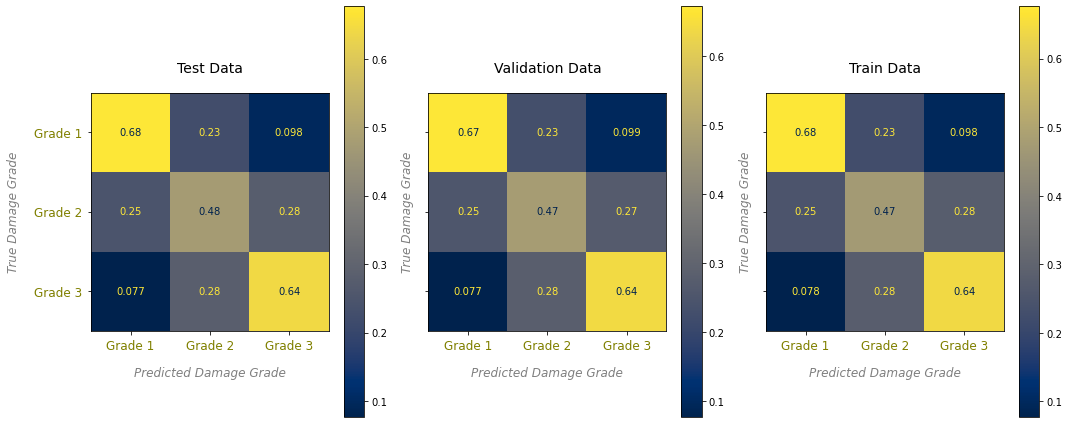

In [119]:
print('Logistic Regression Model Performance')
mfs.plot_confusion_matrices(lr, X_test, y_test, X_val, y_val, X_train, y_train)

Low variance is observed in datasets with this model as the test, validation and training data share similar scores for all metrics.

Recall Score for class 3 is at **64%**

### Random Forest Classifier Model

Please refer to [this notebook](../../notebooks/exploratory/07_random_forest.ipynb) for details on how we arrived at our Random Forest Classifier model.

In [120]:
rfc = RandomForestClassifier(max_depth=12, max_features='sqrt',
                              n_estimators=150,random_state=2015)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, max_features='sqrt', n_estimators=150,
                       random_state=2015)

Random Forest Classifier Performance


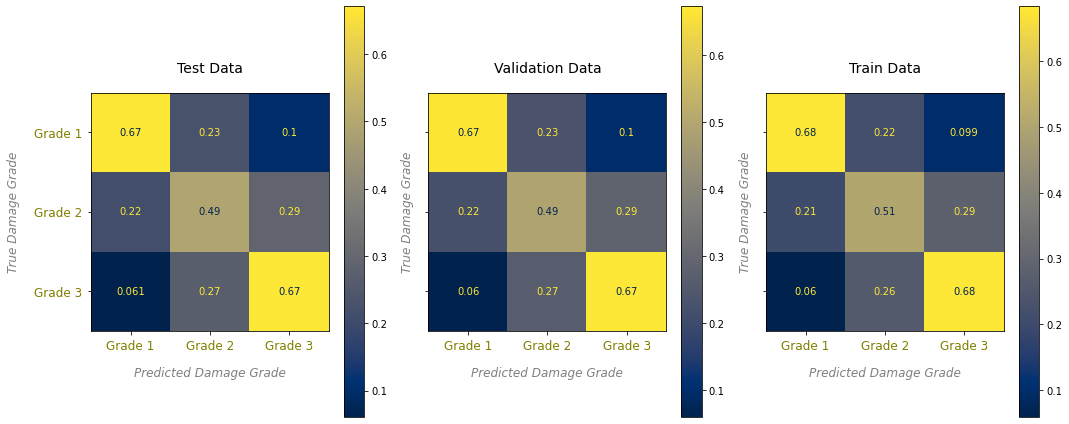

In [121]:
print('Random Forest Classifier Performance')
mfs.plot_confusion_matrices(rfc, X_test, y_test, X_val, y_val, X_train, y_train)

Here again, a generalizable model has been built showing low variance between the datasets. 

Recall for Class 3 is at **67%** with this model

### Gradient Boosting Classifier Model using XGBoost

Please refer to [this notebook](../../notebooks/exploratory/08_xgboost.ipynb) for details on how we arrived at our XGBoost model.

In [124]:
xgbc = xgboost.XGBClassifier(random_state=2015, objective='multi:softmax', num_class=3,
                             learning_rate=0.1, max_depth=6, n_estimators=400)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=2015, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Gradient Boosting Classifier XGBoost Performance


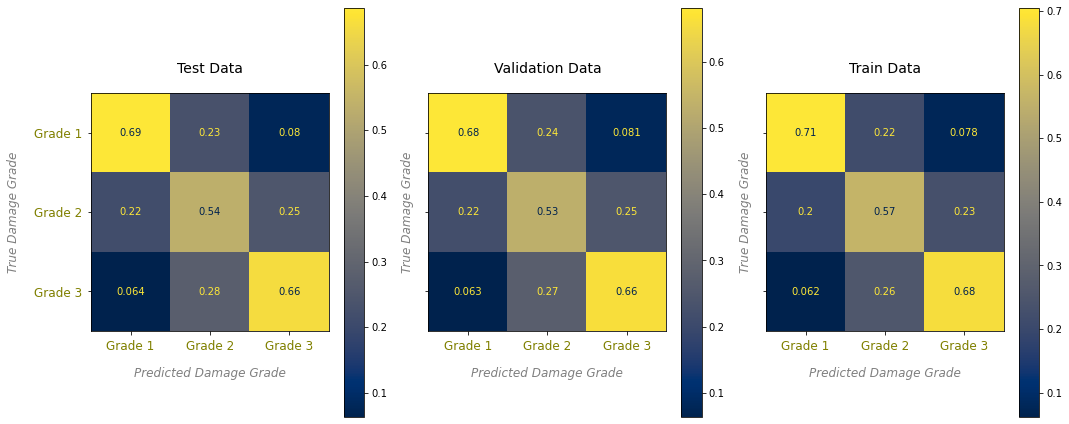

In [125]:
print('Gradient Boosting Classifier XGBoost Performance')
mfs.plot_confusion_matrices(xgbc, X_test, y_test, X_val, y_val, X_train, y_train)

Just as before, we are able to build a reliable model that shows low variance in performance across data sets. 

The Recall score for our priority class is **66%** only marginally lower than our RandomForestClassifier Model. The drawback with this model is its runtime when compared to the Random Forest Classifier, it takes about twice as long to learn.

# Model Evaluation

In [142]:
mfs.print_model_eval_table()

+---------------------------+---------------------------------+
|           Model           | Recall Score for Damage Grade 3 |
+---------------------------+---------------------------------+
|      Random Predictor     |               33%               |
| Logistic Regression Model |               64%               |
|  Random Forest Classifier |               67%               |
|       XGBoost Model       |               66%               |
+---------------------------+---------------------------------+


Based on Recall Score for Class 3, our Metric for evaluating model performance, Random Forest Classifer Model performs better than the other classifiers with a recall score of 67%

The hyperparameters for our chosen model are:
- max_depth=12
- max_features='sqrt'
- n_estimators=150

In [145]:
print('Classification Report for best performer')
print('===========================================================')
print(classification_report(y_test, rfc.predict(X_test)))

Classification Report for best performer
              precision    recall  f1-score   support

         1.0       0.66      0.67      0.67     33245
         2.0       0.29      0.49      0.37     27146
         3.0       0.85      0.67      0.75     92028

    accuracy                           0.64    152419
   macro avg       0.60      0.61      0.59    152419
weighted avg       0.71      0.64      0.66    152419



Our best performing model is able to predict our Class 3 buildings with **67%** recall rate and **75%** f1-score

The overall accuracy of our model is at a modest 64% 

### Feature Analysis 
based on our best performing model - the identified important building parameters that help classify buildings into the 3 different damage grades are:

In [147]:
important_features = list(zip(X_train.columns, rfc.feature_importances_))

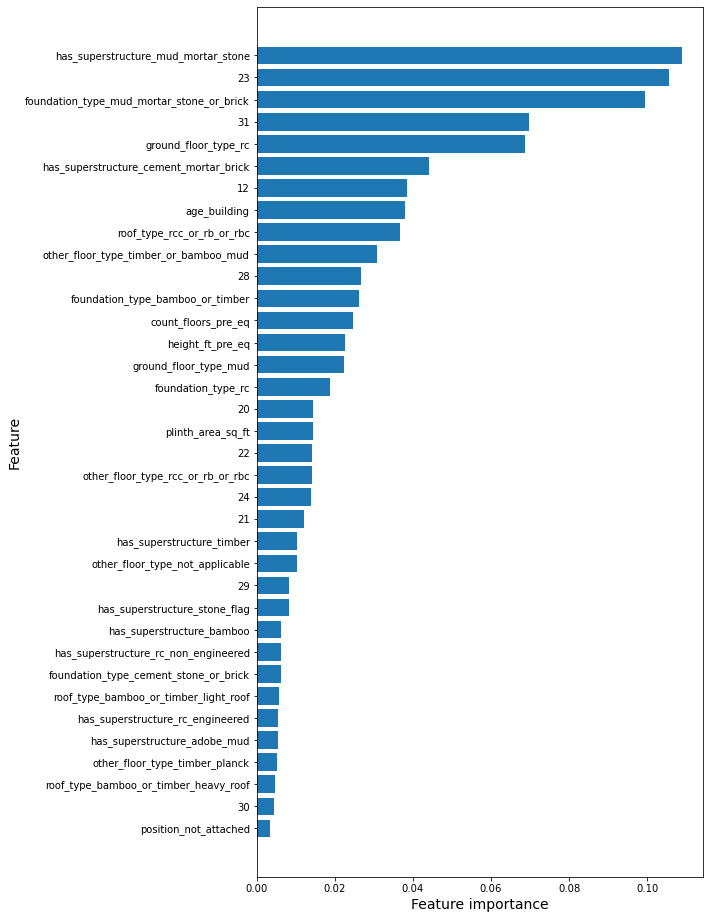

In [159]:
mfs.plot_important_features(important_features)

# Conclusion:

This project set out to discover a predictive model that would correctly classify buildings in the region of Nepal based on their potential vulnerability to earthquakes. The model studied the past behaviour of the buildings in the region to be able to predict future failures. Our analysis and model found Random Forest Classifer with 150 estimators and max tree depth of 12 to be our best performer that maximized our recall score for Class 3 at 67%. The overall performance of the model is at an accuracy of 64%. Important building parameters were identified using the best performing model.

## Future Investigations:

- From the identified important features from our current model further investigation can be conducted to establish relationship between the building features and the varrying damage grades. 
- Can a black box model such as a Neural Net give us better predictions for our 3 classes?
- Can we build an app that takes in parameters of buildings in the region of Nepal and give us predictions regarding their potential vulnerability (damage grade)

